In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import StudentT
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import math
from scipy.stats import norm
from collections import defaultdict
from random import uniform
from tqdm import tqdm
import scipy.stats
from scipy.integrate import quad
from torch.optim.optimizer import Optimizer, required
from __future__ import annotations
import pytest

In [2]:
class ArbitraryMomentumSGD(Optimizer):
    def __init__(self, params, lr=required, momentum_schedule=None):
        """
        Custom SGD that accepts arbitrary momentum (can be negative or >1).
        
        Arguments:
        - params: model parameters
        - lr: learning rate
        - momentum_schedule: callable or float.
            If callable: should return momentum given current step.
            If float: fixed momentum value.
        """
        defaults = dict(lr=lr, momentum_schedule=momentum_schedule, step=0)
        super(ArbitraryMomentumSGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step."""

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            step = group['step']
            momentum_schedule = group['momentum_schedule']

            # Evaluate momentum
            if callable(momentum_schedule):
                momentum = momentum_schedule(step)
            else:
                momentum = momentum_schedule

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                # Initialize velocity if not present
                state = self.state[p]
                if 'velocity' not in state:
                    state['velocity'] = torch.zeros_like(p.data)

                v = state['velocity']
                v.mul_(momentum).add_(d_p, alpha=-lr)
                p.data.add_(v)

            # Increment step counter
            group['step'] += 1

        return loss

In [3]:
class SuperModel(nn.Module):
    def __init__(self, d_model, asset_size, h_size, volume_h_size, metrics_h_size, n_layers, batch_size, seq_len,
                 volume_heads, time_heads, asset_heads,
                 value_size, dropout=0.0):
        super().__init__()

        self.A = asset_size
        self.V = value_size
        self.H = h_size
        self.T = seq_len

        self.base_model = MultiTimescaleLSTM(d_model, asset_size, h_size, n_layers, batch_size, seq_len,
                                             volume_heads, time_heads, asset_heads,
                                             value_size, dropout)
                
    def forward(self, x):
        """ x: [B, A, V + 1, T] """
        # <== Reshape data ==>
        volume = x[:, :, 6, :]                       # [B, A, T]
        ohlc = x[:, :, :6, :]                        # [B, A, V, T]
        
        ohlc = ohlc.transpose(1, 3)                  # [B, T, V, A] (Transpose for lstm)
        volume = volume.transpose(1, 2)
        B, T, V, A = ohlc.shape
        
        # <== get model predictions ==>
        mu, sigma, nu, skew = self.base_model(ohlc, volume)
                
        # === Apply Corrections ===
        mu = mu * 0.1
        sigma = 0.02 + F.tanh(sigma) * 0.01
        nu = F.relu(nu) * 0.1
        skew = F.tanh(0.1 * skew)
        
        return mu, sigma, nu, skew    

In [4]:
class FFN(nn.Module):
    "Implements FFN equation."

    def __init__(self, d, d_ff, dropout=0.1):
        super(FFN, self).__init__()
        self.w_1 = nn.Linear(d, d_ff)
        self.w_2 = nn.Linear(d_ff, d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

In [5]:
class MultiTimescaleLSTM(nn.Module):
    def __init__(self, d_model, asset_size, h_size, n_layers, batch_size, seq_len,
                 volume_heads, time_heads, asset_heads,
                 value_size, dropout=0.0):
        super().__init__()

        self.d_model = d_model
        self.H = h_size
        self.A = asset_size
        self.V = value_size
        self.T = seq_len

        # === Layer Norms ===
        self.hidden_norm = nn.LayerNorm(normalized_shape=self.H)
        self.seq_norm = nn.LayerNorm(normalized_shape=self.T)
        self.final_norm = nn.LayerNorm(normalized_shape=self.T*self.H)

        # === Attention Modules ===
        print(f"Value size: {value_size}, Asset size: {asset_size}")
        
        self.temporal_attn = nn.MultiheadAttention(embed_dim=self.H, num_heads=time_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(embed_dim=self.T, num_heads=asset_heads, batch_first=True)
        self.volume_attn = nn.MultiheadAttention(embed_dim=self.T, num_heads=volume_heads, batch_first=True)

        # === LSTM ===
        self.lstm = nn.LSTM(
            input_size=self.d_model,
            hidden_size=self.H,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True
        )

        # ---- Position-wise FFNs (moved out of forward!) ----
        self.pre_fc = nn.Sequential(
            nn.Linear(self.A * self.V, self.d_model // 2),
            nn.ReLU(),
            nn.Linear(self.d_model // 2, self.d_model)
        )
        self.volume_self_fc = FFN(self.T, 4, dropout)
        self.volume_ffn = FFN(self.T, 4, dropout)
        self.final_ffn = FFN(self.T * self.H, 4, dropout)
        
        # ---- Final projection ----
        self.post_fc = nn.Linear(self.T * self.H, 4 * self.A * 2)
        
    def forward(self, ohlc, volume):
        """
        ohlc: [B, T, V, A]
        volume: [B, T, A]
        """
        H = self.H
        B, T, V, A = ohlc.shape

        # logspace transformation
        #ohlc = torch.log1p(ohlc)
        volume = torch.log1p(volume)
        
        ohlc_flat = ohlc.reshape(B, T, A*V)

        pre_fc = self.pre_fc(ohlc_flat) # [B, T, d_model]
        pre_fc = pre_fc.transpose(1, 2) # [B, d_model, T]

        # === Cross-Asset Attention ===
        asset_out, _ = self.cross_attn(pre_fc, pre_fc, pre_fc)  # [B, d_model, T]
        asset_norm = self.seq_norm(asset_out + pre_fc) # [B, d_model, T]

        ##########################
        # === Volume Attention ===
        ##########################
        volume = volume.transpose(1, 2) # [B, A, T]
        volume_self_fc = self.volume_self_fc(volume)
        
        volume_self_attn, _ = self.volume_attn(volume_self_fc, volume_self_fc, volume_self_fc)
        volume_self_norm = self.seq_norm(volume_self_attn + volume_self_fc) # [B, A, T]
        
        volume_ffn = self.volume_ffn(volume_self_norm)
        volume_norm = self.seq_norm(volume_ffn + volume_self_norm) # [B, A, T]

        # === Volume Cross Attention ===
        volume_cross_attn, _ = self.volume_attn(asset_norm, volume_norm, volume_norm)
        volume_cross_norm = self.seq_norm(volume_cross_attn + asset_norm) # [B, d_model, T]
        
        # === LSTM ===
        volume_cross_norm = volume_cross_norm.transpose(1, 2) # [B, T, d_model]
        lstm_out, _ = self.lstm(volume_cross_norm) # [B, T, H]

        # === Temporal Attention with Causal Mask ===
        device = lstm_out.device
        causal_mask = torch.triu(torch.full((T, T), float('-inf')), diagonal=1).to(device) # [B, T, H]
        temp_out, _ = self.temporal_attn(lstm_out, lstm_out, lstm_out, attn_mask=causal_mask) # [B, T, H]
        temp_norm = self.hidden_norm(temp_out + lstm_out)

        # === Reshape and post fc
        temp_flat = temp_norm.reshape(B, T * H) # [B, T*H]

        final_ffn = self.final_ffn(temp_flat) # [B, T*H]        
        final_norm = self.final_norm(final_ffn + temp_flat) # [B, T*H]
        
        final = self.post_fc(final_norm) # [B, 4 * A * 2]
        final = final.view(B, A, 4, 2)

        # === Output Parameters ===
        mu       = final[:, :, 0, :].mean(dim=-1)  # [B, A]
        log_sigma = final[:, :, 1, :] # [B, A, K]
        log_nu    = final[:, :, 2, :] # [B, A, K]
        skew = final[:, :, 3, 0] - final[:, :, 3, 1] # [B, A]

        sigma = torch.exp(log_sigma)
        nu = torch.exp(log_nu)

        return mu, sigma, nu, skew

In [6]:
class VolumeMetaHead(nn.Module):
    def __init__(self, hidden_dim, dropout=0.0):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(8, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 16),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(16, 3 * 2),
        )

    def forward(self, log_volume):
        """
        log_vol: [B, A, T]
        Returns:
            correction: [B, A, out_per_asset]
        """
        # Average across time: create a regime signal per asset
        avg_vol = log_volume.mean(dim=-1, keepdim=True)  # [B, A, 1]
        correction = self.fc(avg_vol)                 # [B, A, out_per_asset]

        B, A, _ = correction.shape
        correction = correction.reshape(B, A, 3, 2)
        return correction

In [7]:
def mixture_student_t_logpdf(x, mus, sigmas, nus, dist_weights):
    """
    Log-likelihood of Mixture of Student-t Distributions.

    Inputs:
        x:           [B, A]       target returns
        mus:         [B, A, K]    mixture component means
        sigmas:      [B, A, K]    std deviations (> 0)
        nus:         [B, A, K]    degrees of freedom (> 2)
        dist_weights:[B, A, K]    mixture weights (normalized)

    Returns:
        log_prob:    [B, A]       log-likelihood of each sample
    """
    x = x.unsqueeze(-1)  # [B, A, 1] to broadcast over K
    t_dist = StudentT(df=nus, loc=mus, scale=sigmas)
    log_pdf = t_dist.log_prob(x)       # [B, A, K]
    log_w = F.log_softmax(dist_weights, dim=-1)  # [B, A, K]
    
    return torch.logsumexp(log_pdf + log_w, dim=-1)  # [B, A]

In [8]:
def mixture_student_t_loss(mu, sigma, nu, skew, target, max_deviation=100.):
    """
    Loss from Mixture of Skewed Student-t Distributions.

    Inputs:
        mu:     [B, A, 2]   Means of two Student-t components
        sigma:  [B, A, 2]   Standard deviations (positive)
        nu:     [B, A, 2]   Degrees of freedom (> 2)
        skew:   [B, A]      Skew factor per sample
        target: [B, A]      Target values

    Returns:
        loss:   scalar      Negative log-likelihood loss
    """
    # Compute mixture weights using skew
    skew_input = torch.stack([skew, -skew], dim=-1)  # [B, A, 2]
    dist_weights = F.softmax(skew_input, dim=-1)     # [B, A, 2]

    # Adjust mu for skew
    mu_adj = torch.stack([mu - skew, mu + skew], dim=-1)

    # Log-likelihood
    log_probs = mixture_student_t_logpdf(target, mu_adj, sigma, nu, dist_weights)  # [B, A]

    # mask extreme values
    #mask = torch.where(abs(target) > max_deviation, 0.0, 1.0)
    #log_probs = log_probs * mask
    
    pdf_loss = -log_probs.mean()
    
    return pdf_loss

In [9]:
class StockDataset():
    def __init__(self, root_dir, seq_len=1024, num_days=1):
        self.seq_len = seq_len
        self.num_days = num_days
        self.root_dir = root_dir
        self.files = self.get_filenames()
        self.data = self.load_data()

    def get_filenames(self):
        files = os.listdir(self.root_dir)
        return files
    
    def load_data(self):
        # Array of dimension [stock name, price category(open, close, high, low, close, volume, date), sequence length]
        data = np.zeros((len(self.files), 8, self.seq_len // self.num_days))
        
        for i, filename in enumerate(self.files):
            
            with open(self.root_dir + '/' + filename, 'r', encoding="utf-8") as file:
                #print(filename)
                #head = file.read(1000)
                #print(head)  # if this looks binary, it's not a JSON file!
                file.seek(0)
                content = json.load(file)
                time_series = content["Time Series (Daily)"]

                df = pd.DataFrame.from_dict(time_series, orient='index')
                df.columns = ['open', 'high', 'low', 'close', 'volume']
                df.index = pd.to_datetime(df.index)
                df = df.apply(pd.to_numeric, errors='coerce')

                o = df[['open']].to_numpy()
                c = df[['close']].to_numpy()
                h = df[['high']].to_numpy()
                l = df[['low']].to_numpy()
                v = df[['volume']].to_numpy()
                t = df.index.to_numpy()

                # All data is aranged from oldest to newest date
                # So we first have to flip the data by [::-1]
                # Percentage change r
                data[i, 0, :] = (o.flatten()[:self.seq_len][::-1][::self.num_days] /
                                 o.flatten()[self.num_days:self.seq_len + self.num_days][::-1][::self.num_days]) -1
                data[i, 1, :] = (c.flatten()[:self.seq_len][::-1][::self.num_days] /
                                 c.flatten()[self.num_days:self.seq_len + self.num_days][::-1][::self.num_days]) -1
                data[i, 2, :] = (h.flatten()[:self.seq_len][::-1][::self.num_days] /
                                 h.flatten()[self.num_days:self.seq_len + self.num_days][::-1][::self.num_days]) -1
                data[i, 3, :] = (l.flatten()[:self.seq_len][::-1][::self.num_days] /
                                 l.flatten()[self.num_days:self.seq_len + self.num_days][::-1][::self.num_days]) -1
                data[i, 4, :] = (c.flatten()[:self.seq_len][::-1][::self.num_days] /
                                 o.flatten()[self.num_days -1:self.seq_len + self.num_days -1][::-1][::self.num_days]) -1
                data[i, 6, :] = (v.flatten()[:self.seq_len][::-1][::self.num_days])

                # convert date to unix time
                dates = t.flatten()[:self.seq_len][::-1][::self.num_days]
                data[i, 7, :] = dates.astype('datetime64[s]')
                data[i, 7, :] = data[i, 7, :].astype('int64')

                file.close()

            # extra statistics
            data[:, 5, :] = data[:, 2, :] - data[:, 3, :] # daily range high - low
    
        return data

    def average(self, decay_fac=0.0):
        
        avg_arr = np.zeros_like(self.data)
        
        for i in range(self.seq_len):
            exp_decay = np.exp(-decay_fac * np.arange(0, self.seq_len - i))
            exp_decay = exp_decay[::-1]
            exp_decay = np.expand_dims(exp_decay, axis=0)
            exp_decay = np.expand_dims(exp_decay, axis=0)
            exp_decay = np.repeat(exp_decay, repeats=len(self.files), axis=0)
            exp_decay = np.repeat(exp_decay, repeats=5, axis=1)
            avg_arr[:,:-1,i] = np.sum(self.data[:,:-1,i:] * exp_decay, axis=-1) / np.sum(exp_decay[:,:,:], axis=-1)
        
        avg_arr[:,-1,:] = self.data[:,-1,:].copy()

        return avg_arr

    def recons_absol(self):
        # this function only provides a test to reconstruct the original shape of the stock prices
        abs_data = np.zeros_like(self.data)
        abs_data[:,:,0] = 1.
        abs_data[:,-1,:] = self.data[:,-1,:]
        # iterate over all timesteps after the first
        for j in range(self.data.shape[2] - 1):
            abs_data[:, :-1, j+1] = abs_data[:, :-1, j] * (1 + self.data[:, :-1, j])

        return abs_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [10]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, target_stock_idx, max_deviation=100.):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len
        self.max_deviation = max_deviation
        self.target_stock_idx = target_stock_idx

    def __len__(self):
        return self.data.shape[-1] -self.seq_len

    def __getitem__(self, idx):
        x = self.data[:, :, idx : idx + self.seq_len]
        
        # Mask extreme input data !!! Not Target !!!
        #mask = torch.where(torch.abs(x) > self.max_deviation, 0.0, 1.0)
        #x = x * mask
        
        y = self.data[:, self.target_stock_idx, idx + self.seq_len]
        return x, y

In [11]:
def split_time_series(data, train_ratio=0.5, val_ratio=0.25):
    time_steps = data.shape[-1]
    #print(f"Time steps: {time_steps}")
    train_end = int(time_steps * train_ratio)
    val_end = int(time_steps * (train_ratio + val_ratio))
    return data[:, :, 0:train_end], data[:, :, train_end:val_end], data[:, :, val_end:]

In [12]:
def get_warmup_cosine_scheduler(optimizer, warmup_steps, plateau_steps, total_steps, lr_max):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return current_step / warmup_steps
        elif (current_step >= warmup_steps) & (current_step <  warmup_steps + plateau_steps):
            return 1.0
        else:
            progress = (current_step - warmup_steps - plateau_steps) / (total_steps - warmup_steps - plateau_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

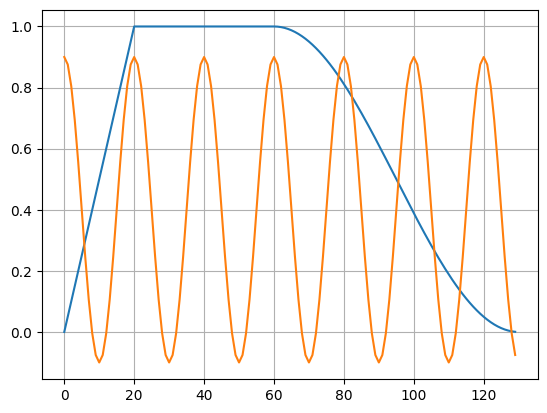

In [13]:
def cyclic_momentum(step):
    return 0.4 + 0.5 * np.cos(2 * np.pi * step / 20)

dummy_warmup_steps = 20
dummy_plateau_steps = 40
dummy_total_steps = 130
dummy_lr = np.zeros(dummy_total_steps)
dummy_momentum = np.zeros(dummy_total_steps)
dummy_steps = np.arange(0, dummy_total_steps, 1)

for step in dummy_steps:
    
    if step < dummy_warmup_steps:
        dummy_lr[step] = step / dummy_warmup_steps
    elif (step >= dummy_warmup_steps) & (step < dummy_warmup_steps + dummy_plateau_steps):
        dummy_lr[step] = 1.0
    else:
        progress = (step - dummy_warmup_steps - dummy_plateau_steps) / (dummy_total_steps - dummy_warmup_steps - dummy_plateau_steps)
        dummy_lr[step] = 0.5 * (1 + math.cos(math.pi * progress))

    dummy_momentum[step] = cyclic_momentum(step)

plt.plot(dummy_steps, dummy_lr)
plt.plot(dummy_steps, dummy_momentum)
plt.grid()
plt.show()

In [14]:
def calc_alloc_return(
    mu, sigma, nu, skew, real_returns,
    cash_threshold=0.5,
    temp=0.01,
    apply_confidence_mask=True,
    min_prob=0.5,
    allow_leverage=False,
    x_grid_points=10000
):
    B, A, K = nu.shape  # batch, assets, components
    device = mu.device

    # Add synthetic 'cash' asset
    mu = torch.cat([mu, torch.zeros(B, 1, device=device)], dim=1)
    sigma = torch.cat([sigma, torch.ones(B, 1, K, device=device) * 0.01], dim=1)
    nu = torch.cat([nu, torch.full((B, 1, K), 100.0, device=device)], dim=1)
    skew = torch.cat([skew, torch.full((B, 1), 0.0, device=device)], dim=1)
    real_returns = torch.cat([real_returns, torch.zeros(B, 1, device=device)], dim=1)

    mu_adj = torch.stack([mu - skew, mu + skew], dim=-1)

    def mix_pdf(x_grid):
        X = x_grid.shape[0]
        B, A, K = nu.shape
    
        # Create full grid: [X, B, A]
        x = x_grid[:, None, None].expand(-1, B, A).reshape(-1)  # [X*B*A]
    
        # Prepare all inputs as [X*B*A, K]
        mu_exp   = mu.unsqueeze(0).expand(X, -1, -1, -1).reshape(-1, K)
        sigma_exp = sigma.unsqueeze(0).expand(X, -1, -1, -1).reshape(-1, K)
        nu_exp    = nu.unsqueeze(0).expand(X, -1, -1, -1).reshape(-1, K)
    
        # Expand skew and apply to mu
        skew_input = torch.stack([skew, -skew], dim=-1)  # [B, A, 2]
        dist_weights = F.softmax(skew_input, dim=-1)     # [B, A, 2]
        mu_adj_exp = mu_adj.unsqueeze(0).expand(X, -1, -1, -1).reshape(-1, K)
        weights_exp = dist_weights.unsqueeze(0).expand(X, -1, -1, -1).reshape(-1, K)

        # Evaluate PDF
        log_probs = mixture_student_t_logpdf(x, mu_adj_exp, sigma_exp, nu_exp, weights_exp)  # [X*B*A]
        return log_probs.reshape(X, B, A).exp()  # [X, B, A]

    def integrate(x, y):
        return torch.trapz(y, x, dim=0)  # ∫_x y dx → [B, A]

    # Main grid for gains and probabilities
    x_grid = torch.linspace(-1.0, 1.0, x_grid_points, device=device)
    pdf = mix_pdf(x_grid)  # [x, B, A]

    norm = integrate(x_grid, pdf)
    pdf = pdf / norm
    
    # calculate the probability to predict the correct direction
    pos_mask = (x_grid > 0).float()[:, None, None]  # [x, 1, 1]
    pos_prob = integrate(x_grid, pdf * pos_mask)    # [B, A]

    # calculate the expected increase
    exp_gain = integrate(x_grid, pdf * x_grid[:, None, None])  # [B, A]

    # compute optimal Leverage
    if allow_leverage:
        
        kelly_grid = torch.linspace(-0.3, 0.3, x_grid_points, device=device)
        kelly_pdf = mix_pdf(kelly_grid)  # [x, B, A]

        norm = integrate(kelly_grid, kelly_pdf)
        kelly_pdf = kelly_pdf / norm
    
        # calculate optimal lever
        optimal_leverage = kelly_from_pdf_grid(
            kelly_grid, kelly_pdf, cost=0.0, l_bounds=(-10, 10), 
            frac_kelly=1.0, iters=100, eps=1e-12, clip_prob=None#(int_bound, 1-int_bound)
        )
        
        # Adjust negative gains to short sell logic
        exp_gain *= torch.abs(optimal_leverage)
        exp_gain = torch.where(exp_gain > 0, exp_gain, 1 / (1 + exp_gain) - 1)

        # calculate the probability to predict the correct direction
        neg_mask = (x_grid < 0).float()[:, None, None]  # [x, 1, 1]
        neg_prob = integrate(x_grid, pdf * neg_mask)    # [B, A]
        pos_prob = torch.where(optimal_leverage < 0, neg_prob, pos_prob)

        # use only strong datapoints with absolute leverage > 1
        #optimal_leverage = torch.where(torch.abs(optimal_leverage) >= 1, optimal_leverage, 0)
    else:
        optimal_leverage = torch.zeros((B, A + 1)) + 1

    # No leverage for cash hold
    optimal_leverage[:, -1] = 0 # [B, 1]

    # sort out low confidence predictions
    if apply_confidence_mask:
        exp_gain *= (pos_prob > min_prob).float()

    # modify exp gain by leverage
    exp_gain = exp_gain * torch.abs(optimal_leverage)
    exp_gain = exp_gain / sigma[:, :, 0]

    # Cash threshold handling
    exp_gain[:, -1] = cash_threshold
    
    # Softmax allocation based on confidence
    alloc_raw = F.softmax(exp_gain / temp, dim=-1)  # [B, A+1]

    single_returns = alloc_raw * real_returns * optimal_leverage # [B, A+1]
    port_ret = single_returns.sum(dim=1)  # [B]

    return alloc_raw, port_ret, single_returns, optimal_leverage

In [15]:
def compute_bootstrap_metrics(returns: torch.Tensor, n_bootstrap: int = 1000, ci: float = 0.95):
    """
    Compute bootstrapped performance metrics (CI) using torch.
    
    Args:
        returns (torch.Tensor): 1D tensor of daily returns.
        n_bootstrap (int): Number of bootstrap samples.
        ci (float): Confidence interval (e.g. 0.95).
    
    Returns:
        dict: {metric: (mean, lower_ci, upper_ci)}
    """
    assert returns.dim() == 1, "Returns must be 1D"
    returns = returns.detach()
    device = returns.device
    N = returns.shape[0]
    alpha = 1 - ci

    metrics = {
        'daily_return': [],
        'cumulative_return': [],
        'annualized_return': [],
        'sharpe_ratio': [],
        'max_drawdown': []
    }

    for _ in range(n_bootstrap):
        # Resample with replacement
        idx = torch.randint(0, N, (N,), device=device)
        sample = returns[idx]

        mean_r = sample.mean()
        std_r = sample.std(unbiased=False)
        sharpe = mean_r / (std_r + 1e-8) * torch.sqrt(torch.tensor(252.0, device=device))

        equity = torch.cumprod(1 + sample, dim=0)
        cum_return = equity[-1] - 1
        annual_ret = equity[-1].pow(252.0 / N * num_days) - 1

        peak = torch.cummax(equity, dim=0)[0]
        drawdown = (equity - peak) / (peak + 1e-8)
        max_dd = drawdown.min()

        metrics['daily_return'].append(mean_r.item())
        metrics['cumulative_return'].append(cum_return.item())
        metrics['annualized_return'].append(annual_ret.item())
        metrics['sharpe_ratio'].append(sharpe.item())
        metrics['max_drawdown'].append(max_dd.item())

    def summarize(values: list[float]):
        values = torch.tensor(values)
        mean = values.mean().item()
        lower = values.kthvalue(int((alpha / 2) * n_bootstrap))[0].item()
        upper = values.kthvalue(int((1 - alpha / 2) * n_bootstrap))[0].item()
        return mean, lower, upper

    return {k: summarize(v) for k, v in metrics.items()}

In [16]:
def calc_performance_metrics(returns: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Differentiable performance metrics using PyTorch ops.
    Assumes returns are daily returns as a 1D tensor.
    """
    # Ensure shape [N]
    returns = returns.view(-1)

    # Cumulative equity curve
    equity_curve = torch.cumprod(1 + returns, dim=0)

    # Annualized return
    total_return = equity_curve[-1]
    annualized_return = total_return.pow(252 / (returns.size(0) * num_days)) - 1

    # Sharpe ratio (risk-free rate = 0)
    sharpe_ratio = returns.mean() / (returns.std(unbiased=False) + 1e-8) * torch.sqrt(torch.tensor(252.0 / num_days, device=returns.device))

    # Max drawdown
    rolling_max, _ = torch.cummax(equity_curve, dim=0)
    drawdowns = (equity_curve - rolling_max) / (rolling_max + 1e-8)
    max_drawdown = drawdowns.min()

    return sharpe_ratio, max_drawdown, annualized_return, equity_curve

In [17]:
# file: kelly_quantile_trim.py
from __future__ import annotations

import torch
from typing import Tuple, Optional


def _trapz_y(x_grid: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """Vectorized trapezoidal integration along the first axis.

    Args:
        x_grid: [X]
        y: [X, ...]
    Returns:
        Integral over the first axis with same trailing shape as ``y``.
    """
    return torch.trapz(y, x_grid, dim=0)


# ---- Quantile-bound utilities -------------------------------------------------

def _cdf_from_pdf_trapz(
    x_grid: torch.Tensor, pdf: torch.Tensor, eps: float = 1e-30
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Compute CDF (via trapezoids) and total mass per asset.

    Works with *shared* X grid.

    Args:
        x_grid: [X]
        pdf: [X, B, A]
        eps: numerical floor to avoid divide-by-zero.
    Returns:
        cdf: [X, B, A] cumulative integral of ``pdf``.
        total: [B, A] total integral (last CDF value).
    """
    X = x_grid.shape[0]
    # Interval areas per bin using trapezoids.
    dx = x_grid[1:] - x_grid[:-1]  # [X-1]
    # [X-1, B, A]
    band = 0.5 * (pdf[1:] + pdf[:-1]) * dx.view(-1, 1, 1)
    csum = torch.cumsum(band, dim=0)  # [X-1, B, A]

    cdf = torch.zeros_like(pdf)
    cdf[1:] = csum
    total = cdf[-1].clamp_min(eps)
    return cdf, total


def _quantile_interval_from_cdf(
    x_grid: torch.Tensor,
    cdf: torch.Tensor,
    total: torch.Tensor,
    q_low: float,
    q_high: float,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Return per-asset indices and fractional positions for [q_low, q_high].

    The returned (iL, tL) identify a point ``xL`` within interval ``[x[iL], x[iL+1]]``
    where ``CDF(xL) == q_low * total``. Similarly for (iH, tH).

    Returns:
        iL, tL, iH, tH with shapes [B, A]; indices are long, t in [0, 1].
    """
    assert 0.0 <= q_low < q_high <= 1.0, "q_low < q_high within [0,1] required"

    X, B, A = cdf.shape
    device, dtype = cdf.device, cdf.dtype

    # Flatten trailing dims for vectorized search over columns.
    N = B * A
    cdf2 = cdf.reshape(X, N)
    total2 = total.reshape(N)

    # Targets in mass units (not normalized CDF to avoid renorm error).
    tgtL = total2 * q_low
    tgtH = total2 * q_high

    # First index j s.t. cdf[j] >= target; j in [0..X-1], guaranteed to exist.
    # boolean argmax trick finds the first True.
    jL = (cdf2 >= tgtL).to(torch.int64).argmax(dim=0)
    jH = (cdf2 >= tgtH).to(torch.int64).argmax(dim=0)

    # Convert to interval index i = j-1, clamped inside [0, X-2].
    iL = (jL - 1).clamp(min=0, max=X - 2)
    iH = (jH - 1).clamp(min=0, max=X - 2)

    # Linear interpolation fraction within each interval.
    # Avoid 0/0 by clamping denominator; fraction set to 0 if degenerate.
    def _frac(j: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        j_prev = (j - 1).clamp(min=0)
        c_prev = cdf2.gather(0, j_prev.unsqueeze(0)).squeeze(0)
        c_curr = cdf2.gather(0, j.unsqueeze(0)).squeeze(0)
        denom = (c_curr - c_prev).clamp_min(1e-30)
        return ((target - c_prev) / denom).clamp(0.0, 1.0)

    tL = _frac(jL, tgtL)
    tH = _frac(jH, tgtH)

    # Back to [B, A]
    iL = iL.view(B, A)
    iH = iH.view(B, A)
    tL = tL.view(B, A).to(dtype=dtype)
    tH = tH.view(B, A).to(dtype=dtype)
    
    return iL, tL, iH, tH


def _trapz_truncated_over_grid(
    x_grid: torch.Tensor,
    g: torch.Tensor,  # [X, B, A]
    iL: torch.Tensor,
    tL: torch.Tensor,
    iH: torch.Tensor,
    tH: torch.Tensor,
) -> torch.Tensor:
    """Integrate ``g(x)`` over per-asset [xL, xH] defined by (i*, t*).

    Uses cumulative trapezoids + linear interpolation within boundary bins.
    This avoids per-asset grid slicing inside iterative solvers.

    Args:
        x_grid: [X]
        g: [X, B, A]
        iL, tL, iH, tH: [B, A]
    Returns:
        Integral per asset: [B, A]
    """
    X, B, A = g.shape
    device, dtype = g.device, g.dtype

    N = B * A
    g2 = g.reshape(X, N)

    dx = (x_grid[1:] - x_grid[:-1]).to(dtype=dtype)  # [X-1]
    # [X-1, N]
    areas = 0.5 * (g2[1:] + g2[:-1]) * dx.view(-1, 1)
    cum = torch.cumsum(areas, dim=0)  # [X-1, N]

    # Cum integral at grid points (prepend zero).
    cumG = g2.new_zeros((X, N))
    cumG[1:] = cum

    # Helper to evaluate CumG at arbitrary x within interval i with fraction t.
    # CumG(x) = CumG[i] + dx_i * ( g_i * t + 0.5 * (g_{i+1} - g_i) * t^2 )
    def eval_at(i: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        i2 = i.view(-1)  # [N]
        t2 = t.view(-1)  # [N]
        ar = torch.arange(N, device=device)
        g_i = g2[i2, ar]
        g_ip1 = g2[i2 + 1, ar]
        cum_i = cumG[i2, ar]
        dx_i = dx[i2]
        return cum_i + dx_i * (g_i * t2 + 0.5 * (g_ip1 - g_i) * t2 * t2)

    iL2, tL2 = iL.reshape(N), tL.reshape(N)
    iH2, tH2 = iH.reshape(N), tH.reshape(N)

    left = eval_at(iL2, tL2)
    right = eval_at(iH2, tH2)

    out = (right - left).view(B, A)
    return out


# ---- Kelly solver with optional quantile trimming -----------------------------

def kelly_from_pdf_grid(
    x_grid: torch.Tensor,
    pdf: torch.Tensor,
    cost: float = 0.0,
    l_bounds: Tuple[float, float] = (-10.0, 10.0),
    frac_kelly: float = 1.0,
    iters: int = 60,
    eps: float = 1e-12,
    clip_prob: Optional[Tuple[float, float]] = (0.05, 0.95),
) -> torch.Tensor:
    """Vectorized bisection to solve E[(r - c) / (1 + L (r - c))] = 0 per asset.

    Integrals are evaluated on a shared X grid. If ``clip_prob`` is provided, we
    truncate the integral to the central [q_low, q_high] quantile interval of the
    *pdf* for each asset (per-asset bounds, same grid).

    Args:
        x_grid: [X]
        pdf: [X, B, A]
        cost: scalar transaction cost (shift in r)
        l_bounds: global L bracket (lo, hi)
        frac_kelly: scale the final solution
        iters: max bisection iterations
        eps: unused; kept for API compatibility
        clip_prob: (q_low, q_high) within [0,1], or None for full support
    Returns:
        L_opt: [B, A]
    """
    X, B, A = pdf.shape
    device, dtype = pdf.device, pdf.dtype

    # Shift by cost for domain.
    y = (x_grid - cost).to(device=device, dtype=dtype)  # [X]

    # Global feasible domain from full grid (safe when trimming too).
    y_pos = y[y > 0]
    y_neg = y[y < 0]
    L_low_f = (-1.0 / y_pos.max()) if y_pos.numel() else float("-inf")
    L_high_f = (-1.0 / y_neg.min()) if y_neg.numel() else float("inf")

    L_lo, L_hi = l_bounds
    L_low = max(L_lo, L_low_f)
    L_high = min(L_hi, L_high_f)

    # Small nudges to stay strictly inside domain.
    L_left = torch.tensor(L_low + 1e-10, device=device, dtype=dtype)
    L_right = torch.tensor(L_high - 1e-10, device=device, dtype=dtype)

    # Precompute per-asset quantile bounds once (independent of L).
    if clip_prob is not None:
        q_low, q_high = clip_prob
        cdf, total = _cdf_from_pdf_trapz(x_grid, pdf)
        iL, tL, iH, tH = _quantile_interval_from_cdf(x_grid, cdf, total, q_low, q_high)
    else:
        # Full support: [x[0], x[-1]] → interval index = 0..X-2, t ∈ {0, 1}
        iL = torch.zeros((B, A), device=device, dtype=torch.long)
        tL = torch.zeros((B, A), device=device, dtype=dtype)
        iH = torch.full((B, A), X - 2, device=device, dtype=torch.long)
        tH = torch.ones((B, A), device=device, dtype=dtype)

    # Vectorized f(L): [B, A]
    y_col = y.view(X, 1, 1)

    def f_of_L(L: torch.Tensor) -> torch.Tensor:
        denom = 1.0 + y_col * L.view(1, B, A)
        # Jacobian kept at 1.0; change only if variable transform is applied.
        integrand = (y_col / denom) * pdf
        if clip_prob is None:
            return _trapz_y(x_grid, integrand)
        # Truncated integral per asset.
        return _trapz_truncated_over_grid(x_grid, integrand, iL, tL, iH, tH)

    f_low = f_of_L(L_left.expand(B, A))
    f_high = f_of_L(L_right.expand(B, A))

    # Initialize brackets per asset.
    a = L_left.expand(B, A).clone()
    b = L_right.expand(B, A).clone()
    fa = f_low.clone()
    fb = f_high.clone()

    # If no sign change, choose a boundary.
    no_root_low = (fa < 0) & (fb < 0)
    no_root_high = (fa > 0) & (fb > 0)
    root_mask = ~(no_root_low | no_root_high)

    L_star = torch.where(no_root_low, a, torch.where(no_root_high, b, 0.5 * (a + b)))

    for _ in range(iters):
        if not root_mask.any():
            break
        m = 0.5 * (a + b)
        fm = f_of_L(m)

        left_side = (fa * fm > 0) & root_mask
        a[left_side] = m[left_side]
        fa[left_side] = fm[left_side]

        right_side = (~left_side) & root_mask
        b[right_side] = m[right_side]
        fb[right_side] = fm[right_side]

        L_star[root_mask] = 0.5 * (a[root_mask] + b[root_mask])

        if (b - a).abs()[root_mask].max() < 1e-8:
            break

    return frac_kelly * L_star

In [18]:
# Dataset parameters
num_days = 1 # How many days is each datapoint?
data_seq_len = 160 # How many days are considered in the dataset

train_ratio = 0.4
val_ratio = 0.3
max_deviation = 100.0 # Mask extreme data

# lstm model parameters
d_model = 512
h_size = 128
n_layers = 4

volume_heads = 16
time_heads = 2
asset_heads = 16

dropout = 0.3
seq_len = 16
batch_size = 1

num_experts = 1

# Meta head parameters
volume_h_size = 24
metrics_h_size = 32

# training main model
warmup_steps = 50
plateau_steps = 10
total_steps = 200
lr_max=5e-5
weight_decay = 0.0
momentum_cycle = 20
static_momentum = 0.98
periodic_momentum = 0.0

# Training online learning model
#lr_single = 1e-5
#weight_decay_single = 0.0 #1e-6
#momentum_single = 0.9

Stock names: ['MRNA', 'PEP', 'ENR', 'INTC', 'IBM', 'NFLX', 'MSFT', 'TSLA', 'CSCO', 'AAPL', 'JNJ', 'AMZN', 'MO', 'BAYN', 'BAS', 'ON', 'ADBE', 'SAP', 'AVGO', 'NVDA', 'ALV', 'SIE']
num stocks: 22

Interval return Train     : 6.23%
Interval return Validation: -10.30%
Interval return Test      : 21.83%

Trainig window adjusted return Train     : 2.25%
Trainig window adjusted return Validation: -9.32%
Trainig window adjusted return Test      : 9.21%


/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_17863/130997483.py:90: RuntimeWarning: overflow encountered in multiply
  abs_data[:, :-1, j+1] = abs_data[:, :-1, j] * (1 + self.data[:, :-1, j])


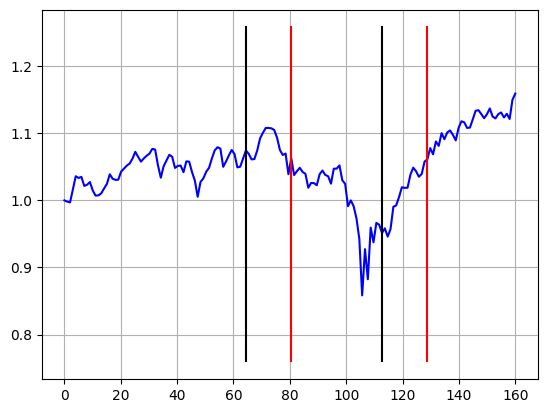

In [19]:
root_dir = "/Users/silas/work/machine_learning/LSTM/data/data_dump"
#root_dir = "/Users/silas/work/machine_learning/LSTM/data/my_repo"
stock_data = StockDataset(root_dir, seq_len=data_seq_len, num_days=num_days)

stock_nr = 3
stock_names = [name.split(".")[0] for name in stock_data.files]
print(f"Stock names: {stock_names}")

num_stocks = len(stock_data.files)
print(f"num stocks: {num_stocks}")
print()

abs_data = stock_data.recons_absol()
x = np.linspace(0, len(abs_data[stock_nr,-1,:]), len(abs_data[stock_nr,-1,:]))
y = np.mean(abs_data[:,0,:], axis=0)

val_idx = int(train_ratio*len(x))
test_idx = int((train_ratio + val_ratio)*len(x))

val_cut = x[val_idx]
test_cut = x[test_idx]

train_data = y[:val_idx]
val_data = y[val_idx:test_idx]
test_data = y[test_idx:]

for arr, text in zip([train_data, val_data, test_data], ["Train     ", "Validation", "Test      "]):
    interval_return = arr[-1] / arr[0] -1
    print(f"Interval return {text}: {interval_return:.2%}")

print()
for arr, text in zip([train_data, val_data, test_data], ["Train     ", "Validation", "Test      "]):
    buy_and_hold = arr[-1] / arr[seq_len] -1
    print(f"Trainig window adjusted return {text}: {buy_and_hold:.2%}")
    
plt.plot(x, y, color="blue")
plt.grid()
plt.vlines([val_cut, test_cut], np.min(y) - 0.1, np.max(y) + 0.1, color="black") # train/val/test split
plt.vlines([val_cut + seq_len, test_cut + seq_len], np.min(y) - 0.1, np.max(y) + 0.1, color="red") # window adjusted train/val/test split
plt.show()

In [20]:
data = stock_data.data[:,:7,:] # Pass OHLC

target_stock_idx = 5 # [open, close, high, low, high - low, close-open, volume, datetime]

value_size = data.shape[1] -1 # OHLC
in_size = len(stock_data.files) # number of stocks

print(f"Stock dimension: {stock_data.data.shape}")
print(f"Value size: {value_size}")

Stock dimension: (22, 8, 160)
Value size: 6


In [21]:
###############
#### Data #####
###############
train, val, test = split_time_series(data, train_ratio=train_ratio, val_ratio=val_ratio)
print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

train_ds = TimeSeriesDataset(train, seq_len, target_stock_idx, max_deviation)
val_ds = TimeSeriesDataset(val, seq_len, target_stock_idx, max_deviation)
test_ds = TimeSeriesDataset(test, seq_len, target_stock_idx, max_deviation)
#print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

# (Batch, in_size, seq_len)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Shapes: train=(22, 7, 64) val=(22, 7, 48) test=(22, 7, 48)


In [22]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"device: {device}")

device: cpu


In [23]:
for i_exp in range(num_experts):
    
    torch.manual_seed(torch.initial_seed() + i_exp)

    model = SuperModel(d_model, in_size, h_size, volume_h_size, metrics_h_size, n_layers, batch_size, seq_len, volume_heads, 
                           time_heads, asset_heads, value_size, dropout).to(device)
    torch.save({
            'model_state_dict': model.state_dict(),
            #'optimizer_state_dict': optimizer.state_dict(),
        }, f"{i_exp}_pre_trained.pth")

optimizer = ArbitraryMomentumSGD(
    model.parameters(),
    lr=lr_max,
    momentum_schedule=lambda step: static_momentum + periodic_momentum * torch.cos(2 * torch.pi * torch.tensor(step) / torch.tensor(momentum_cycle))  # Cyclic μ in [-0.1, 0.9]
)

scheduler = get_warmup_cosine_scheduler(
    optimizer, warmup_steps=warmup_steps, plateau_steps=plateau_steps, total_steps=total_steps, lr_max=lr_max
)

Value size: 6, Asset size: 22


In [24]:
##################
#### Training ####
##################

# Set some parameters for the calc_alloc_return function
train_cash_threshold = 0.005
train_temp = 0.005
train_min_prob = 0.5
allow_leverage=False

returns_buffer = []

# Train LSTM model
for train_step in range(total_steps):
        
    all_train_losses = []
    all_val_losses = []

    for i_exp in range(num_experts):

        # load all models
        checkpoint = torch.load(f"{i_exp}_pre_trained.pth")
        model.load_state_dict(checkpoint["model_state_dict"])
        
        # Training
        model.train()

        # Counting variable for permutation change
        perm_counter = train_step
        perm = torch.randperm(in_size, device=device)

        for batch_x, batch_y in train_loader:
                
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
    
            B, A, V, T = batch_x.shape

            if perm_counter % 5 == 0:
                # Generate a random permutation of assets
                perm = torch.randperm(A, device=batch_x.device)
            
            # Apply same permutation to both tensors along dim=1
            batch_x = batch_x[:, perm, :, :]
            batch_y = batch_y[:, perm]
    
            # train stock predictor
            optimizer.zero_grad()
            mu, sigma, nu, skew = model(batch_x)
            loss = mixture_student_t_loss(mu, sigma, nu, skew, batch_y, max_deviation)
    
            loss.backward()
    
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.02)
        
            optimizer.step()
            all_train_losses.append(loss.item())

            perm_counter += 1

        torch.save({
            'model_state_dict': model.state_dict(),
            #'optimizer_state_dict': optimizer.state_dict(),
        }, f"{i_exp}_pre_trained.pth")

    scheduler.step()
    avg_train_loss = np.mean(all_train_losses)

    # Validation
    val_loss = 0

    returns_buffer = []
    total_ret, sample_count = 0, 0
    
    for val_x, val_y in val_loader:
        val_x = val_x.to(device)
        val_y = val_y.to(device)

        mu = torch.zeros((num_experts, B, in_size))
        sigma = torch.zeros((num_experts, B, in_size, 2))
        nu = torch.zeros((num_experts, B, in_size, 2))
        skew = torch.zeros((num_experts, B, in_size))

        loss = torch.zeros(num_experts)
        
        for i_exp in range(num_experts):

            # load all models
            checkpoint = torch.load(f"{i_exp}_pre_trained.pth")
            model.load_state_dict(checkpoint["model_state_dict"])

            model.eval()

            mu[i_exp, :, :], sigma[i_exp, :, :, :], nu[i_exp, :, :, :], skew[i_exp, :, :] = model(val_x)
            loss[i_exp] = mixture_student_t_loss(mu[i_exp], sigma[i_exp], nu[i_exp], skew[i_exp], val_y, max_deviation).item()

        mu_std = mu.std(dim=0)
        mu = mu.mean(dim=0) # [B, A]
        sigma = sigma.mean(dim=0) # [B, A, 2]
        nu = nu.mean(dim=0)
        skew = skew.mean(dim=0)
            
        all_val_losses.append(loss.mean())

        alloc, port_ret, single_returns, leverage = calc_alloc_return(
                            mu, sigma, nu, skew, val_y,
                            cash_threshold=train_cash_threshold,
                            temp=train_temp,
                            apply_confidence_mask=False,
                            min_prob=train_min_prob,
                            allow_leverage=allow_leverage
                        )
        
        returns_buffer.append(port_ret)  # accumulate tensors directly
        total_ret += port_ret.sum().item()
        sample_count += port_ret.shape[0]

    returns_tensor = torch.cat(returns_buffer, dim=0)  # shape [N], retains grad
    
    sharpe_ratio, max_drawdown, annualized_return, equity_curve = calc_performance_metrics(returns_tensor)
                        
    avg_val_loss = np.mean(all_val_losses)
            
    if (train_step % 5 == 4):
        
        group = optimizer.param_groups[0]
        step = group['step']
        momentum_schedule = group['momentum_schedule']
        current_momentum = momentum_schedule(step)

        print(f"<========== Training metrics ==========>")
        print(f"Step              : {train_step+1}/{total_steps}")
        print(f"LR in microns     : {scheduler.get_last_lr()[0]*10e6:.1f}")
        print(f"Current Momentum  : {current_momentum:.2f}")
        print()
        print(f"Train Loss        : {avg_train_loss:.4f}")
        print(f"Validation Loss   : {avg_val_loss:.4f}")
        print(f"mu std            : {mu_std[0, :].mean(dim=-1):.4f}")
        print(f"<========== Quick Validation set Performance ==========>")
        print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
        print(f"Annualized return: {annualized_return:.2%}")
        print(f"Sharpe ratio: {sharpe_ratio:.2f}")
        print(f"Max drawdown: {max_drawdown:.2%}")
        print(f"mu: {torch.abs(mu).mean():.4f} [{mu.min():.4f}, {mu.max():.4f}]")
        print(f"sigma: {sigma.mean():.4f} [{sigma.min():.4f}, {sigma.max():.4f}]")
        print(f"nu: {nu.mean():.4f} [{nu.min():.4f}, {nu.max():.4f}]")
        print(f"Skew: {torch.abs(skew).mean():.4f} [{skew.min():.4f}, {skew.max():.4f}]")
        print(f"Maximum target {torch.max(batch_y):.4f}")
        print()

/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_17863/3946206997.py:98: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  mu_std = mu.std(dim=0)


<========== Training metrics ==========>
Step              : 5/200
LR in microns     : 50.0
Current Momentum  : 0.98

Train Loss        : 0.3535
Validation Loss   : 0.3778
mu std            : nan
<========== Quick Validation set Performance ==========>
Final cumulative return: -4.66%
Annualized return: -31.34%
Sharpe ratio: -0.64
Max drawdown: -9.75%
mu: 0.0265 [-0.0664, 0.0493]
sigma: 0.0269 [0.0226, 0.0299]
nu: 0.1275 [0.0484, 0.3176]
Skew: 0.0890 [-0.2228, 0.2404]
Maximum target 0.0235

<========== Training metrics ==========>
Step              : 10/200
LR in microns     : 100.0
Current Momentum  : 0.98

Train Loss        : 0.3303
Validation Loss   : 0.3586
mu std            : nan
<========== Quick Validation set Performance ==========>
Final cumulative return: -4.57%
Annualized return: -30.81%
Sharpe ratio: -0.61
Max drawdown: -10.31%
mu: 0.0265 [-0.0664, 0.0490]
sigma: 0.0269 [0.0226, 0.0299]
nu: 0.1277 [0.0484, 0.3187]
Skew: 0.0884 [-0.2227, 0.2404]
Maximum target 0.0235

<======

In [34]:
##############################
#### single step learning ####
##############################

cash_threshold = 0.00
temp = 0.005
min_prob = 0.60

allow_leverage = False

# Training Parameters
lr_single = 1e-4
weight_decay_single = 0.0
momentum_single = 0.99

# Adapt optimizer parameters
#optimizer.param_groups[0]['lr'] = lr_single
#optimizer.param_groups[0]['weight_decay'] = weight_decay_single
#optimizer.param_groups[0]['momentum'] = momentum_single

sgd_opt = ArbitraryMomentumSGD(
    model.parameters(),
    lr=lr_single,
    momentum_schedule=lambda step: momentum_single + 0.0 * torch.tensor(step)  # Cyclic μ in [-0.1, 0.9]
)

# Now first calculate performance and the train

returns_buffer = []
allocs_buffer = []
single_returns_buffer = []
leverage_returns_buffer = []
total_ret, sample_count = 0, 0

train_loss = 0

train_iters = 1
training_steps = 10

train, val, test = split_time_series(data, train_ratio=train_ratio, val_ratio=val_ratio)
data_set = test

# Use pretrained model and train for a few datapoints before evaluating each datapoint
for k in range(data_set.shape[-1] - training_steps - seq_len - 1):

    train_ds = TimeSeriesDataset(data_set[:, :, k: k + seq_len + training_steps + 1], 
                                 seq_len, target_stock_idx, max_deviation)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
    
    for i_exp in range(num_experts):

        # Reset to pre trained state for every iteration
        model = SuperModel(d_model, in_size, h_size, volume_h_size, metrics_h_size, n_layers, batch_size, seq_len, volume_heads, 
                   time_heads, asset_heads, value_size, dropout=dropout).to(device)
        
        checkpoint = torch.load(f"{i_exp}_pre_trained.pth")
        model.load_state_dict(checkpoint["model_state_dict"])
    
        torch.save({
                'model_state_dict': model.state_dict(),
                #'optimizer_state_dict': optimizer.state_dict(),
            }, f"{i_exp}_trained.pth")

    data_pair = 0
    for train_x, train_y in train_loader:

        for s in range(train_iters):

            #if s < train_iters -1:
                # Generate a random permutation of assets
                #perm = torch.randperm(A, device=batch_x.device)
                
                # Apply same permutation to both tensors along dim=1
                #train_x = train_x[:, perm, :, :]
                #train_y = train_y[:, perm]
            
            ###################
            ### First train ###
            ###################
            if data_pair < training_steps - 1:
                for i_exp in range(num_experts):
            
                    checkpoint = torch.load(f"{i_exp}_trained.pth")
                    model.load_state_dict(checkpoint["model_state_dict"])
                    
                    model.train()
                
                    train_x = train_x.to(device)
                    train_y = train_y.to(device)
            
                    # train stock predictor
                    sgd_opt.zero_grad()
                    mu, sigma, nu, skew = model(train_x)
                    loss = mixture_student_t_loss(mu, sigma, nu, skew, train_y, max_deviation)
                
                    train_loss += loss.item()
                
                    loss.backward()
                    sgd_opt.step()
        
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        #'optimizer_state_dict': optimizer.state_dict(),
                    }, f"{i_exp}_trained.pth")

        #####################
        ### Then evaluate ###
        #####################
        if data_pair == training_steps - 1:
                    
            mu = torch.zeros((num_experts, B, in_size))
            sigma = torch.zeros((num_experts, B, in_size, 2))
            nu = torch.zeros((num_experts, B, in_size, 2))
            skew = torch.zeros((num_experts, B, in_size))
        
            for i_exp in range(num_experts):
                
                checkpoint = torch.load(f"{i_exp}_trained.pth")
                model.load_state_dict(checkpoint["model_state_dict"])
                
                model.eval()
            
                mu[i_exp, :, :], sigma[i_exp, :, :, :], nu[i_exp, :, :, :], skew[i_exp, :, :] = model(train_x)
        
            mu = mu.mean(dim=0) # [B, A]
            sigma = sigma.mean(dim=0) # [B, A, 2]
            nu = nu.mean(dim=0)
            skew = skew.mean(dim=0)
        
            alloc, port_ret, single_returns, leverage = calc_alloc_return(mu, sigma, nu, skew, train_y, 
                                                        cash_threshold=cash_threshold,
                                                        temp=temp,
                                                        apply_confidence_mask=True,
                                                        min_prob=min_prob,
                                                        allow_leverage=allow_leverage
                                                   )
        
            single_returns_buffer.append(single_returns)
            leverage_returns_buffer.append(leverage)
            returns_buffer.append(port_ret)  # accumulate tensors directly
            allocs_buffer.append(alloc)
            total_ret += port_ret.sum().item()
            sample_count += port_ret.shape[0]
        
        data_pair +=1

avg_train_loss = 0.0 #train_loss / (len(x) - training_steps - 1)

returns_tensor = torch.cat(returns_buffer, dim=0)  # shape [N], retains grad
sharpe_ratio, max_drawdown, annualized_return, equity_curve = calc_performance_metrics(returns_tensor)

print(f"<========== Online Learaning Performance ==========>")
print(f"Loss                   : {avg_train_loss:.4f}")
print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
print(f"Annualized return      : {annualized_return:.2%}")
print(f"Sharpe ratio           : {sharpe_ratio:.2f}")
print(f"Max drawdown           : {max_drawdown:.2%}")
print(f"mu                     : {mu.mean():.4f} [{mu.min():.4f}, {mu.max():.4f}]")
print(f"sigma                  : {sigma.mean():.4f} [{sigma.min():.4f}, {sigma.max():.4f}]")
print(f"nu                     : {nu.mean():.4f} [{nu.min():.4f}, {nu.max():.4f}]")
print(f"Skew                   : {skew.mean():.4f} [{skew.min():.4f}, {skew.max():.4f}]")

Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
Value size: 6, Asset size: 22
<========== Online Learaning Performance ==========>
Loss                   : 0.0000
Final cumulative return: 1.72%
Annualized return      : 22.66%
Sharpe ratio           : 1.33
Max drawdown           : -1.94%
mu                     : -0.0045 [-0.0924, 0.0428]
sigma                  : 0.0270 [0.0225, 0.0299]
nu                     : 0.1502 [0.0534, 0.3973]
Skew       

In [35]:
print(f"\n<========== Final Test Performance ==========>")
print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
print(f"Buy and Hold return: {buy_and_hold:.2%}")
print(f"Annualized return: {annualized_return:.2%}")
print(f"Sharpe ratio: {sharpe_ratio:.2f}")
print(f"Max drawdown: {max_drawdown:.2%}")

print(f"\n<========== S&P 500 Performance ==========>")
print(f"Final cumulative return: {0.285 * len(equity_curve) / 390:.2%}")
print(f"Annualized return: 18.9%")
print(f"Sharpe ratio: 1.40")
print(f"Max drawdown: -8%")

print()
print(f"Number of samples: {len(equity_curve)}")

print(f"\n<========== Bootstrap results ==========>")
results = compute_bootstrap_metrics(returns_tensor, n_bootstrap=1000, ci=0.95)
for name, (mean_val, low, high) in results.items():
    print(f"{name.replace('_', ' ').title()}: {mean_val*100:.2f}% "
          f"[{low*100:.2f}%, {high*100:.2f}%]")


<========== Final Test Performance ==========>
Final cumulative return: 1.72%
Buy and Hold return: 9.21%
Annualized return: 22.66%
Sharpe ratio: 1.33
Max drawdown: -1.94%

<========== S&P 500 Performance ==========>
Final cumulative return: 1.53%
Annualized return: 18.9%
Sharpe ratio: 1.40
Max drawdown: -8%

Number of samples: 21

<========== Bootstrap results ==========>
Daily Return: 0.09% [-0.39%, 0.51%]
Cumulative Return: 1.99% [-7.89%, 11.26%]
Annualized Return: 46.68% [-62.72%, 259.69%]
Sharpe Ratio: 153.64% [-652.88%, 893.28%]
Max Drawdown: -3.98% [-9.20%, -1.33%]


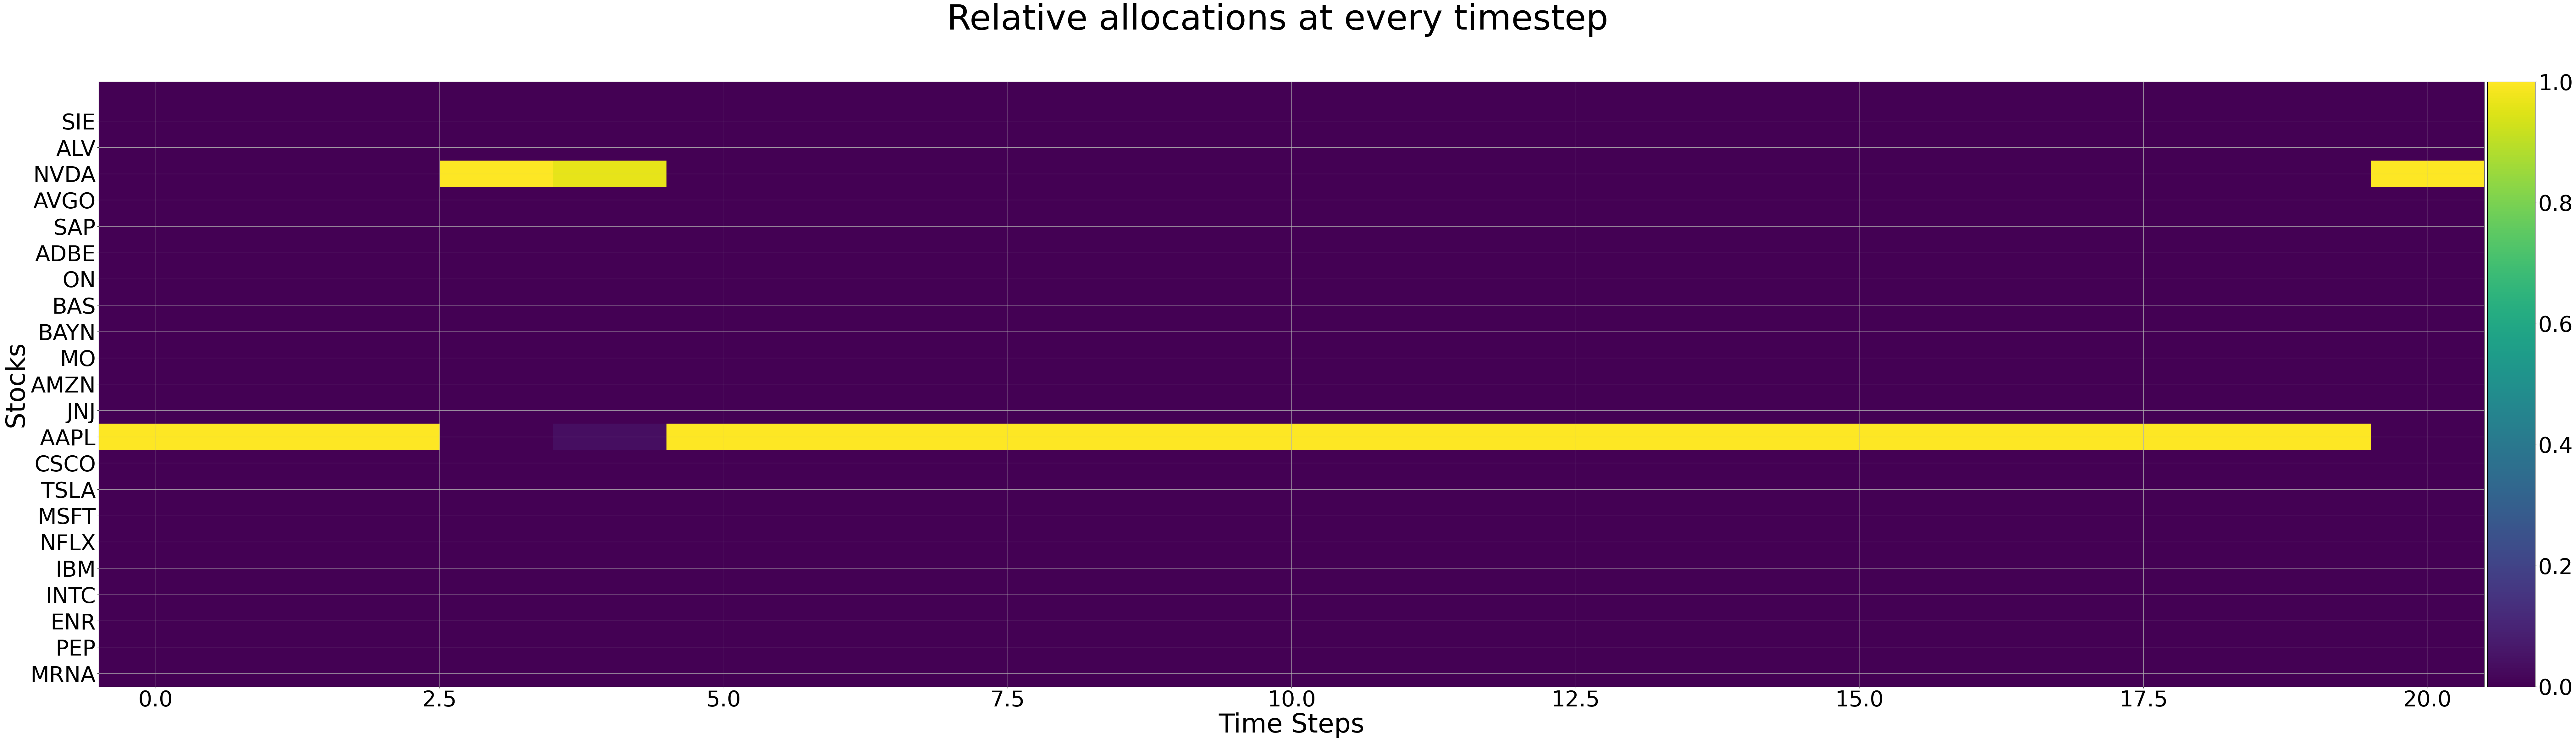

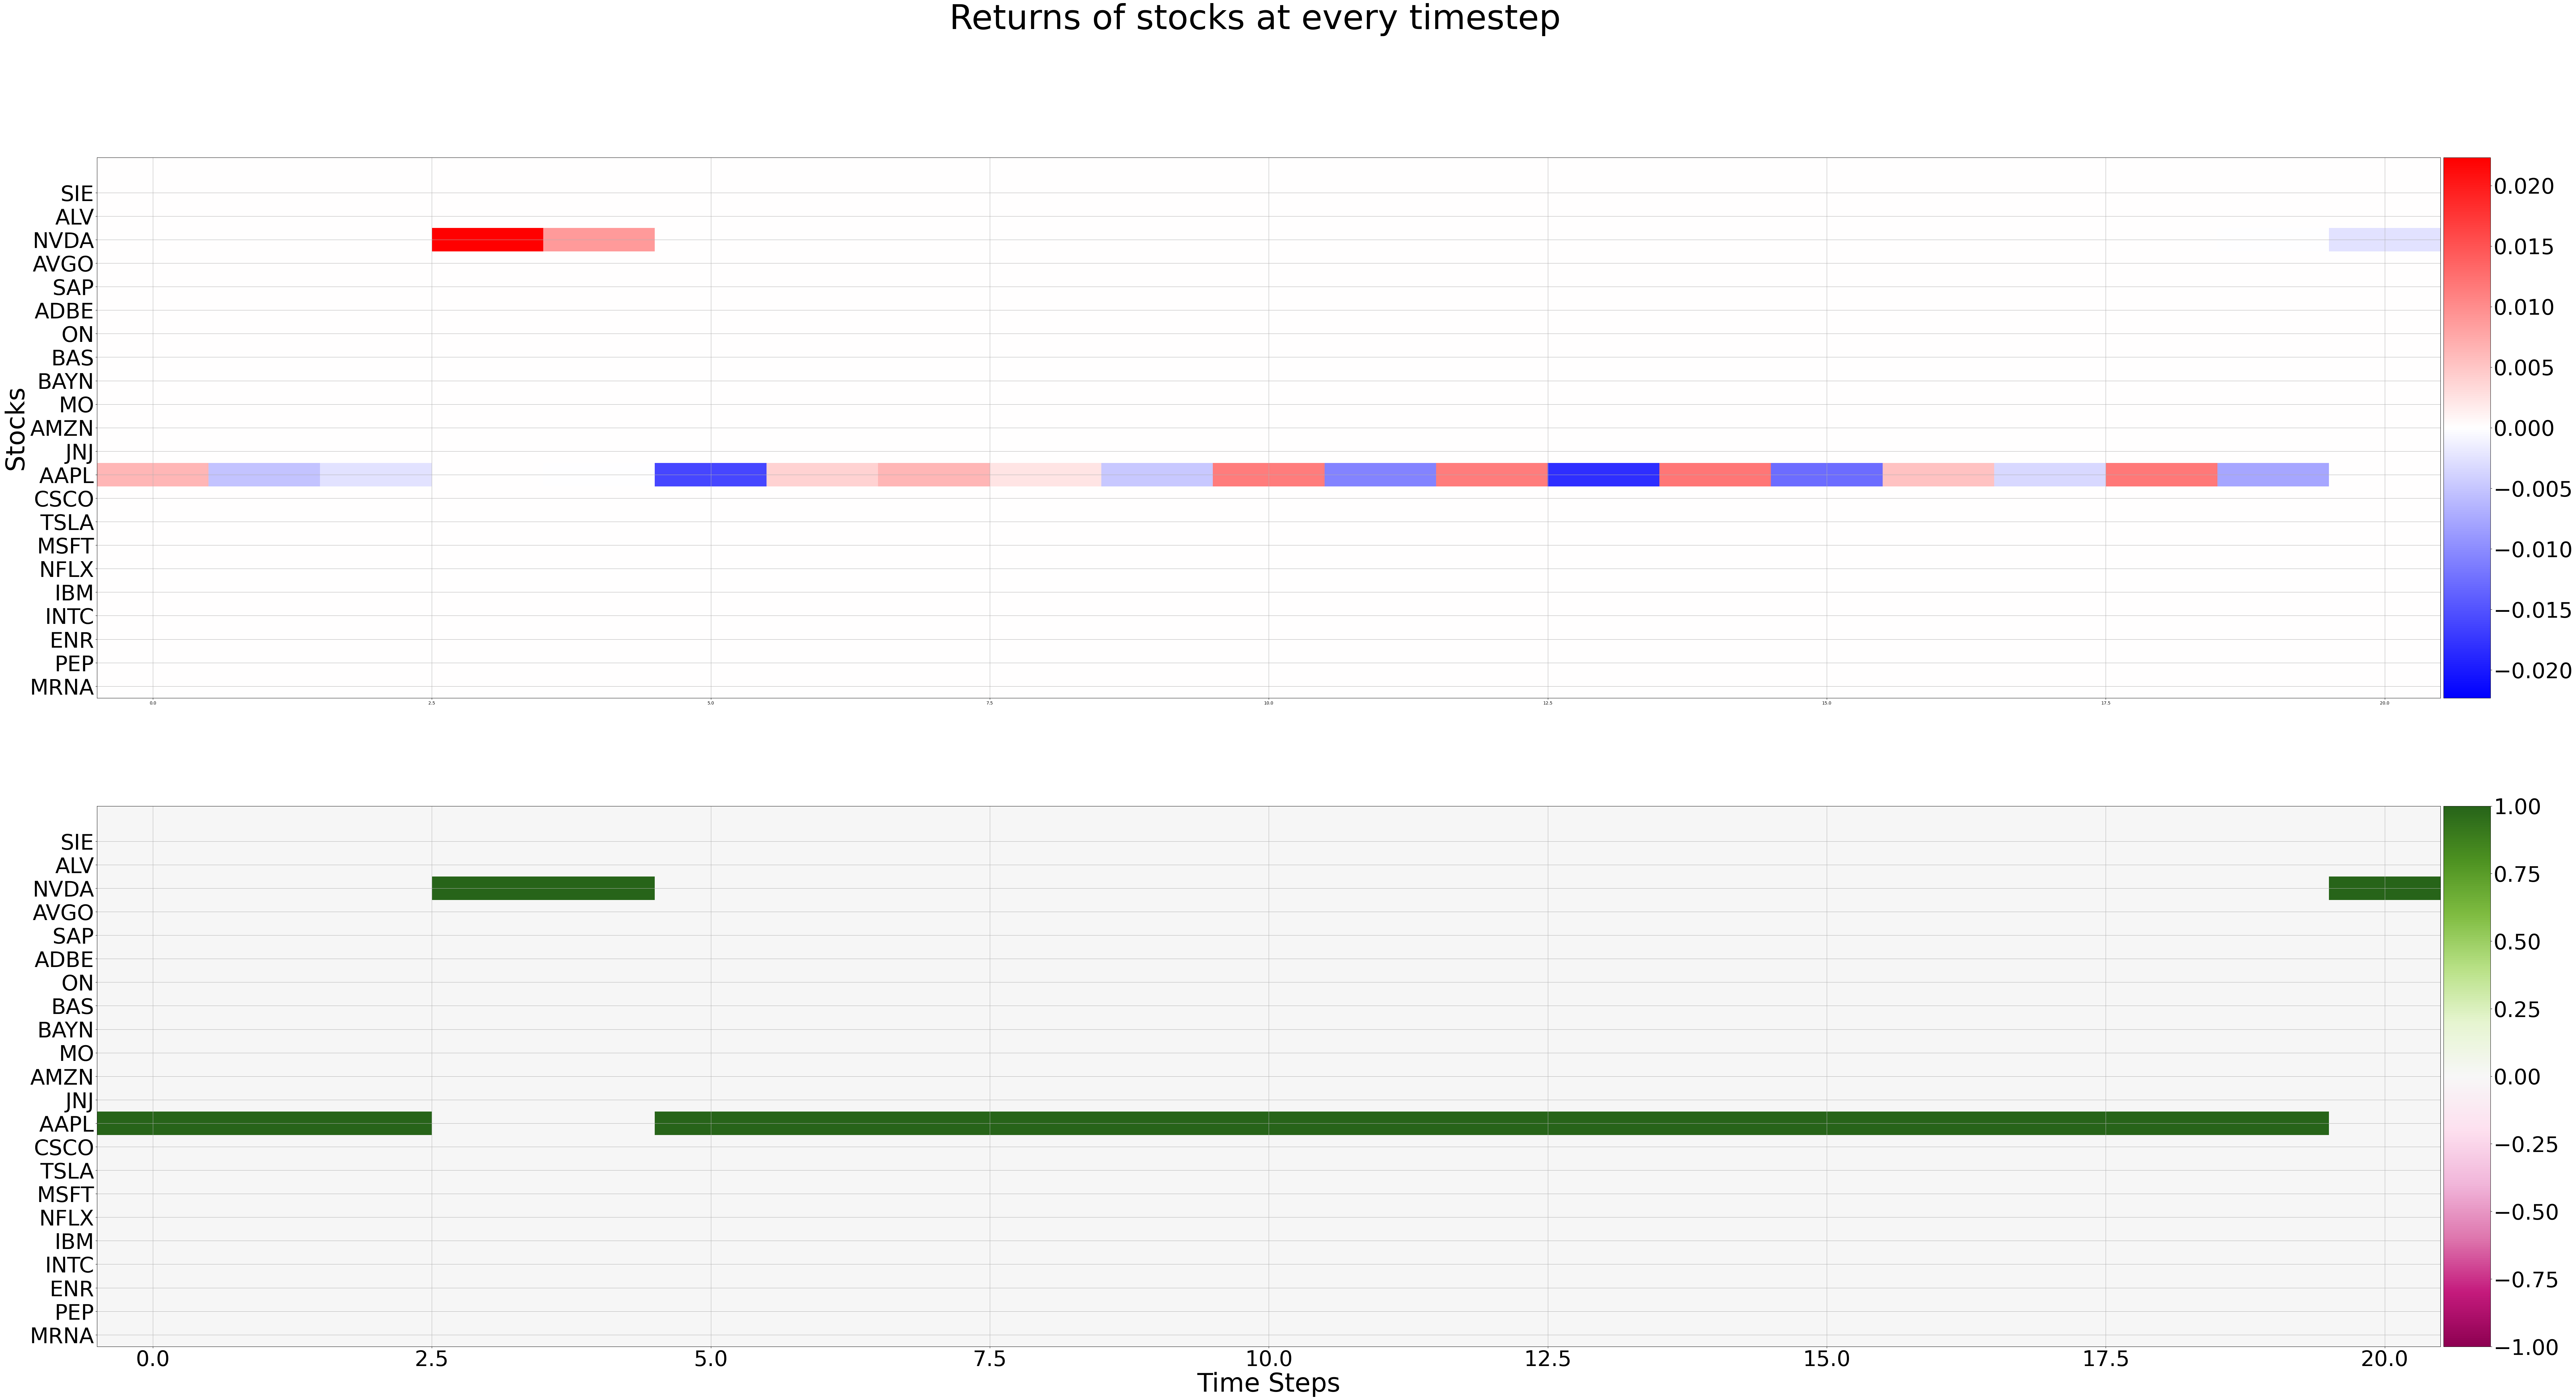

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

stock_names = [filename.split(".")[0] for filename in stock_data.files]

# Assuming all_allocs and stock_data are already defined
allocs_tensor = torch.cat(allocs_buffer, dim=0)
allocs_tensor = allocs_tensor.detach().cpu().numpy()

single_returns_tensor = torch.cat(single_returns_buffer, dim=0)
single_returns_tensor = single_returns_tensor.detach().cpu().numpy()

leverage_returns_tensor = torch.cat(leverage_returns_buffer, dim=0)
leverage_returns_tensor = leverage_returns_tensor.detach().cpu().numpy()

#################
## Allocations ##
#################
alloc_fig, alloc_ax = plt.subplots(figsize=(100, 25))  # Large figure

# Use make_axes_locatable to attach a smaller colorbar axis
divider = make_axes_locatable(alloc_ax)
cax = divider.append_axes("right", size="2%", pad=0.1)  # Smaller colorbar

# Plot heatmap
image = alloc_ax.imshow(allocs_tensor.T, origin="lower", vmin=0, aspect="auto")

# Colorbar with bigger font
cb = alloc_fig.colorbar(image, cax=cax)
cb.ax.tick_params(labelsize=50)

# Bigger tick labels on y-axis
alloc_ax.set_yticks(range(len(stock_names)))
alloc_ax.set_yticklabels(stock_names, rotation=0, ha="right", rotation_mode="anchor", fontsize=50)

# Bigger tick labels on x-axis
alloc_ax.tick_params(axis="x", labelsize=50)

# Bigger axis labels if needed
alloc_ax.set_xlabel("Time Steps", fontsize=60)
alloc_ax.set_ylabel("Stocks", fontsize=60)

alloc_ax.grid()

#################
#### Returns ####
#################

fig, (ret_ax, lev_ax) = plt.subplots(
    nrows=2,
    figsize=(100, 50),
    gridspec_kw={"height_ratios": [1, 1]}
)

# Use make_axes_locatable to attach a smaller colorbar axis
ret_divider = make_axes_locatable(ret_ax)
ret_cax = ret_divider.append_axes("right", size="2%", pad=0.1)  # Smaller colorbar

# Plot heatmap
max_value = np.max(np.abs(single_returns_tensor))
image = ret_ax.imshow(
    single_returns_tensor.T, origin="lower", vmin=-max_value, vmax=max_value, aspect="auto", cmap="bwr"
)

# Colorbar with bigger font
ret_cb = fig.colorbar(image, cax=ret_cax)
ret_cb.ax.tick_params(labelsize=50)

# Bigger tick labels on y-axis
ret_ax.set_yticks(range(len(stock_names)))
ret_ax.set_yticklabels(stock_names, rotation=0, ha="right", rotation_mode="anchor", fontsize=50)

ret_ax.set_ylabel("Stocks", fontsize=60)

ret_ax.grid()

# Use make_axes_locatable to attach a smaller colorbar axis
lev_divider = make_axes_locatable(lev_ax)
lev_cax = lev_divider.append_axes("right", size="2%", pad=0.1)  # Smaller colorbar

#############
### Lever ###
#############
leverage_returns_tensor = np.where(
    allocs_tensor > 0.1, leverage_returns_tensor, 0)

max_leverage = np.max(np.abs(leverage_returns_tensor))
leverage_image = lev_ax.imshow(
    leverage_returns_tensor.T, origin="lower", vmin=-max_leverage, vmax=max_leverage, aspect="auto", cmap="PiYG"
)

# Colorbar with bigger font
lev_cb = fig.colorbar(leverage_image, cax=lev_cax)
lev_cb.ax.tick_params(labelsize=50)

# Bigger tick labels on x-axis
lev_ax.tick_params(axis="x", labelsize=50)

# Bigger axis labels if needed
lev_ax.set_xlabel("Time Steps", fontsize=60)

lev_ax.grid()

# Bigger tick labels on y-axis
lev_ax.set_yticks(range(len(stock_names)))
lev_ax.set_yticklabels(stock_names, rotation=0, ha="right", rotation_mode="anchor", fontsize=50)

alloc_fig.suptitle("Relative allocations at every timestep", fontsize=80)
fig.suptitle("Returns of stocks at every timestep", fontsize=80)

plt.show()